In [ ]:
# Cell 1: Clone and update repository
import os

# Clone if not already cloned
if not os.path.exists('Protein_RL_Project'):
    !git clone https://github.com/xiw-1202/Protein_RL_Project.git
    print("✓ Repository cloned")
else:
    print("✓ Repository already exists")

# Navigate to project
%cd Protein_RL_Project

# Pull latest changes (includes all fixes)
!git pull origin main

# Verify improved methods exist
print("\n" + "="*70)
print("VERIFYING FILES")
print("="*70)

files_to_check = [
    'src/rl_methods/ppo_optimizer_v2.py',
    'src/rl_methods/contextual_bandit_ucb.py',
    'run_experiments.py'
]

all_good = True
for file in files_to_check:
    if os.path.exists(file):
        print(f"✓ {file}")
    else:
        print(f"✗ {file} - MISSING!")
        all_good = False

if all_good:
    print("\n✓✓✓ All required files present!")
else:
    print("\n✗✗✗ Some files missing - check git pull output above")

Cloning into 'Protein_RL_Project'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 123 (delta 57), reused 89 (delta 27), pack-reused 0 (from 0)
Receiving objects: 100% (123/123), 291.24 KiB | 15.33 MiB/s, done.
Resolving deltas: 100% (57/57), done.
✓ Repository cloned
/content/Protein_RL_Project/Protein_RL_Project
From https://github.com/xiw-1202/Protein_RL_Project
 * branch            main       -> FETCH_HEAD
Already up to date.

VERIFYING FILES
✓ src/rl_methods/ppo_optimizer_v2.py
✓ src/rl_methods/contextual_bandit_ucb.py
✓ run_experiments.py

✓✓✓ All required files present!


In [ ]:
# ============================================================================
# STEP 1.5: Download Dataset from ProteinGym
# ============================================================================

import requests
import zipfile
import shutil
from pathlib import Path
import pandas as pd

print("=" * 70)
print("DOWNLOADING DATASETS FROM PROTEINGYM")
print("=" * 70)

# Create directories
Path("data/raw/dms_datasets").mkdir(parents=True, exist_ok=True)
Path("data/raw/wild_types").mkdir(parents=True, exist_ok=True)

# Your 4 datasets
MY_DATASETS = [
    "PITX2_HUMAN_Tsuboyama_2023_2L7M",      # Person 1
    "SRC_HUMAN_Ahler_2019",                  # Person 2
    "PAI1_HUMAN_Huttinger_2021",            # Person 3A
    "CBPA2_HUMAN_Tsuboyama_2023_1O6X",      # Person 3B
    "SAV1_MOUSE_Tsuboyama_2023_2YSB",       # Person 4A
    "CCR5_HUMAN_Gill_2023"                   # Person 4B
]

# Download ProteinGym ZIP file
url = "https://marks.hms.harvard.edu/proteingym/ProteinGym_v1.3/DMS_ProteinGym_substitutions.zip"

print(f"\nDownloading ProteinGym database (~500 MB)...")
print("This takes 5-10 minutes depending on connection speed")
print("-" * 70)

response = requests.get(url, stream=True)
total_size = int(response.headers.get('content-length', 0))
downloaded = 0
chunk_size = 8192

print(f"Total size: {total_size / (1024*1024):.0f} MB\n")

with open('proteingym.zip', 'wb') as f:
    for chunk in response.iter_content(chunk_size=chunk_size):
        if chunk:
            f.write(chunk)
            downloaded += len(chunk)

            # Print progress every 50MB
            if downloaded % (50 * 1024 * 1024) < chunk_size:
                percent = 100 * downloaded / total_size
                mb_downloaded = downloaded / (1024 * 1024)
                mb_total = total_size / (1024 * 1024)
                print(f"  Progress: {percent:.0f}% ({mb_downloaded:.0f}/{mb_total:.0f} MB)")

print(f"\n✓ Download complete! ({total_size / (1024*1024):.0f} MB)")

# Extract all our datasets
print(f"\nExtracting datasets...")
print("=" * 70)

dataset_info = []

with zipfile.ZipFile('proteingym.zip', 'r') as z:
    all_files = z.namelist()

    for dataset_name in MY_DATASETS:
        print(f"\n[{dataset_name}]")
        print("-" * 70)

        # Find the file for this dataset
        matching_files = [f for f in all_files if dataset_name in f and f.endswith('.csv')]

        if matching_files:
            target_file = matching_files[0]
            print(f"  Found: {target_file}")

            # Extract to temporary location
            z.extract(target_file, 'temp_extract')

            # Move to final location
            extracted_path = Path('temp_extract') / target_file
            final_path = Path(f'data/raw/dms_datasets/{dataset_name}.csv')
            shutil.move(str(extracted_path), str(final_path))

            # Load and analyze the dataset
            df = pd.read_csv(final_path)

            # Get wild-type sequence (it's in the first row)
            if 'mutant' in df.columns:
                # Get wild-type from first mutation
                first_mutation = df['mutant'].iloc[0]
                # Wild-type is usually stored in a separate column or we extract it
                # For now, let's get sequence length from mutation positions

                # Count unique positions to estimate sequence length
                positions = []
                for mut in df['mutant']:
                    if isinstance(mut, str) and len(mut) > 0:
                        # Parse mutation like "A123B" or "A123B:C456D"
                        for single_mut in mut.split(':'):
                            if len(single_mut) >= 3:
                                # Extract position number
                                pos_str = ''.join([c for c in single_mut[1:-1] if c.isdigit()])
                                if pos_str:
                                    positions.append(int(pos_str))

                seq_length = max(positions) if positions else 0
            else:
                seq_length = 0

            n_variants = len(df)
            file_size = final_path.stat().st_size / 1024  # KB

            dataset_info.append({
                'dataset': dataset_name,
                'variants': n_variants,
                'seq_length': seq_length,
                'file_size_kb': file_size
            })

            print(f"  ✓ Saved to: {final_path}")
            print(f"  Variants: {n_variants:,}")
            print(f"  Estimated sequence length: {seq_length} AA")
            print(f"  File size: {file_size:.1f} KB")
        else:
            print(f"  ✗ ERROR: Not found in ProteinGym ZIP!")

# Clean up temporary files
print("\nCleaning up...")
!rm proteingym.zip
!rm -rf temp_extract

# Show summary and recommendation
print("\n" + "=" * 70)
print("DATASET SUMMARY")
print("=" * 70)

summary_df = pd.DataFrame(dataset_info)
summary_df = summary_df.sort_values('seq_length')

print("\nDatasets sorted by sequence length (smallest first):")
print("-" * 70)
for idx, row in summary_df.iterrows():
    print(f"{row['dataset']:<45} {row['seq_length']:>4} AA, {row['variants']:>6,} variants")

# Recommend smallest
if len(summary_df) > 0:
    smallest = summary_df.iloc[0]

    print("\n" + "=" * 70)
    print("RECOMMENDATION FOR IMPROVED RL EXPERIMENTS")
    print("=" * 70)
    print(f"\n✓ Use: {smallest['dataset']}")
    print(f"  Sequence length: {smallest['seq_length']} amino acids")
    print(f"  Number of variants: {smallest['variants']:,}")
    print(f"\nWhy: Shortest sequence = fastest experiments!")
    print(f"  Estimated time: {smallest['seq_length'] / 269 * 6:.1f}-{smallest['seq_length'] / 269 * 10:.1f} hours")
    print(f"  (vs 6-10 hours for 269 AA sequence)")

    # Set recommended dataset for next cells
    RECOMMENDED_DATASET = smallest['dataset']

    print(f"\n✓ {RECOMMENDED_DATASET} is ready for experiments!")
    print("=" * 70)
else:
    print("\n✗ No datasets were downloaded successfully!")

print("\n✓ Dataset download complete!")
print("=" * 70)

DOWNLOADING DATASETS FROM PROTEINGYM

This takes 5-10 minutes depending on connection speed
----------------------------------------------------------------------
Total size: 41 MB


✓ Download complete! (41 MB)

Extracting datasets...

[PITX2_HUMAN_Tsuboyama_2023_2L7M]
----------------------------------------------------------------------
  Found: DMS_ProteinGym_substitutions/PITX2_HUMAN_Tsuboyama_2023_2L7M.csv
  ✓ Saved to: data/raw/dms_datasets/PITX2_HUMAN_Tsuboyama_2023_2L7M.csv
  Variants: 1,824
  Estimated sequence length: 52 AA
  File size: 145.8 KB

[SRC_HUMAN_Ahler_2019]
----------------------------------------------------------------------
  Found: DMS_ProteinGym_substitutions/SRC_HUMAN_Ahler_2019.csv
  ✓ Saved to: data/raw/dms_datasets/SRC_HUMAN_Ahler_2019.csv
  Variants: 3,372
  Estimated sequence length: 519 AA
  File size: 1838.9 KB

[PAI1_HUMAN_Huttinger_2021]
----------------------------------------------------------------------
  Found: DMS_ProteinGym_substitutions/PAI

In [ ]:
# ============================================================================
# STEP 1.6: Extract Wild-Type Sequence from Dataset
# ============================================================================

import pandas as pd
from pathlib import Path

print("=" * 70)
print("EXTRACTING WILD-TYPE SEQUENCE")
print("=" * 70)

# Use the recommended dataset from previous cell
# Or manually set it here:
DATASET_TO_USE = RECOMMENDED_DATASET  # From previous cell

print(f"\nDataset: {DATASET_TO_USE}")
print("-" * 70)

# Load the dataset
df = pd.read_csv(f'data/raw/dms_datasets/{DATASET_TO_USE}.csv')

print(f"Total variants: {len(df):,}")

# Extract wild-type sequence from mutations
# Strategy: Build wild-type by looking at what gets replaced
wt_sequence = {}

for idx, row in df.iterrows():
    mutant = row['mutant']

    if isinstance(mutant, str) and len(mutant) > 0:
        # Parse mutations (format: "A123B" or "A123B:C456D")
        for single_mut in mutant.split(':'):
            if len(single_mut) >= 3:
                wt_aa = single_mut[0]  # Wild-type amino acid
                pos_str = ''.join([c for c in single_mut[1:-1] if c.isdigit()])

                if pos_str:
                    pos = int(pos_str)

                    # Store wild-type AA for this position
                    if pos not in wt_sequence:
                        wt_sequence[pos] = wt_aa
                    elif wt_sequence[pos] != wt_aa:
                        # Conflict - this shouldn't happen
                        print(f"  ⚠️ Warning: Position {pos} has conflicting WT: {wt_sequence[pos]} vs {wt_aa}")

# Build the sequence string
if wt_sequence:
    max_pos = max(wt_sequence.keys())
    sequence = ''.join([wt_sequence.get(i, 'X') for i in range(1, max_pos + 1)])

    # Remove any 'X' placeholders
    sequence = sequence.replace('X', '')

    print(f"\n✓ Wild-type sequence extracted!")
    print(f"  Length: {len(sequence)} amino acids")
    print(f"  Coverage: {len(wt_sequence)}/{max_pos} positions")
    print(f"\n  First 60 AA: {sequence[:60]}...")
    print(f"  Last 60 AA:  ...{sequence[-60:]}")

    # Save as FASTA
    fasta_filename = f"{DATASET_TO_USE.split('_')[0]}_{DATASET_TO_USE.split('_')[1]}"
    fasta_path = f'data/raw/wild_types/{fasta_filename}.fasta'

    with open(fasta_path, 'w') as f:
        f.write(f">{fasta_filename}\n")
        f.write(sequence + "\n")

    print(f"\n✓ Saved to: {fasta_path}")

    # Update dataset for experiments
    EXPERIMENT_DATASET = fasta_filename

    print("\n" + "=" * 70)
    print("READY FOR EXPERIMENTS!")
    print("=" * 70)
    print(f"\nDataset: {EXPERIMENT_DATASET}")
    print(f"Sequence: {len(sequence)} amino acids")
    print(f"FASTA file: {fasta_path}")
    print("\n✓ Proceed to Cell 2 (Install Dependencies)")
    print("=" * 70)

else:
    print("\n✗ ERROR: Could not extract wild-type sequence!")
    print("Please check the dataset format.")

EXTRACTING WILD-TYPE SEQUENCE

Dataset: SAV1_MOUSE_Tsuboyama_2023_2YSB
----------------------------------------------------------------------
Total variants: 965

✓ Wild-type sequence extracted!
  Length: 42 amino acids
  Coverage: 42/43 positions

  First 60 AA: GEDLPLPPGSVDWTMRGRKYYIDHNTNTTHWSHPLESGPSSG...
  Last 60 AA:  ...GEDLPLPPGSVDWTMRGRKYYIDHNTNTTHWSHPLESGPSSG

✓ Saved to: data/raw/wild_types/SAV1_MOUSE.fasta

READY FOR EXPERIMENTS!

Dataset: SAV1_MOUSE
Sequence: 42 amino acids
FASTA file: data/raw/wild_types/SAV1_MOUSE.fasta

✓ Proceed to Cell 2 (Install Dependencies)


In [ ]:
# Cell 2: Install all required packages
print("Installing PyTorch with CUDA support...")
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

print("Installing ESM-2 and other dependencies...")
!pip install -q fair-esm pandas numpy matplotlib seaborn scikit-learn

print("\n" + "="*70)
print("✓ All dependencies installed")
print("="*70)

Installing PyTorch with CUDA support...
Installing ESM-2 and other dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 8.8 MB/s eta 0:00:00

✓ All dependencies installed


In [ ]:
# Cell 6: Mount Google Drive for saving results
from google.colab import drive
import os

# Mount drive
drive.mount('/content/drive')

# Create output directory
output_base = "/content/drive/MyDrive/Protein_RL_Results"
output_dir = f"{output_base}/SAV1_MOUSE_improved_RL"

os.makedirs(output_dir, exist_ok=True)

print("="*70)
print("GOOGLE DRIVE SETUP")
print("="*70)
print(f"✓ Google Drive mounted")
print(f"✓ Output directory: {output_dir}")
print(f"\nAll results will be saved to Google Drive.")
print(f"Safe to disconnect - results are preserved!")
print("="*70)

Mounted at /content/drive
GOOGLE DRIVE SETUP
✓ Google Drive mounted
✓ Output directory: /content/drive/MyDrive/Protein_RL_Results/SAV1_MOUSE_improved_RL

All results will be saved to Google Drive.
Safe to disconnect - results are preserved!


In [ ]:
# Cell 7: Set experiment parameters
print("="*70)
print("EXPERIMENT CONFIGURATION")
print("="*70)

# Configuration
DATASET = "SAV1_MOUSE"
METHODS = ["ppo_v2", "ucb1", "ucb_tuned"]
K_VALUES = [1, 3, 5, 10]
SEEDS = [42, 123, 456, 789, 1011]
BUDGET = 300
MODEL = "esm2_t33_650M_UR50D"
DEVICE = "cuda"

# Calculate total
total_experiments = len(METHODS) * len(K_VALUES) * len(SEEDS)

print(f"Dataset: {DATASET}")
print(f"Methods: {', '.join(METHODS)}")
print(f"k-values: {K_VALUES}")
print(f"Seeds: {SEEDS}")
print(f"Budget per experiment: {BUDGET} queries")
print(f"Model: {MODEL}")
print(f"Device: {DEVICE}")
print(f"\nTotal experiments: {total_experiments}")
print(f"  = {len(METHODS)} methods × {len(K_VALUES)} k-values × {len(SEEDS)} seeds")

# Time estimate
min_per_exp = 4.5  # SAV1_MOUSE average
max_per_exp = 7.5
min_total = total_experiments * min_per_exp / 60
max_total = total_experiments * max_per_exp / 60

print(f"\nEstimated time: {min_total:.1f} - {max_total:.1f} hours")
print(f"  (≈{min_per_exp}-{max_per_exp} min per experiment)")

print(f"\nOutput: {output_dir}")
print("="*70)

# Confirm before proceeding
print("\n⚠️  This is a long-running experiment!")
print("✓ Results auto-save to Google Drive")
print("✓ Can resume if disconnected (--resume flag)")
print("✓ Monitor progress in Cell 9")
print("\nReady to start? Run Cell 8 to begin.")

EXPERIMENT CONFIGURATION
Dataset: SAV1_MOUSE
Methods: ppo_v2, ucb1, ucb_tuned
k-values: [1, 3, 5, 10]
Seeds: [42, 123, 456, 789, 1011]
Budget per experiment: 300 queries
Model: esm2_t33_650M_UR50D
Device: cuda

Total experiments: 60
  = 3 methods × 4 k-values × 5 seeds

Estimated time: 4.5 - 7.5 hours
  (≈4.5-7.5 min per experiment)

Output: /content/drive/MyDrive/Protein_RL_Results/SAV1_MOUSE_improved_RL

⚠️  This is a long-running experiment!
✓ Results auto-save to Google Drive
✓ Can resume if disconnected (--resume flag)
✓ Monitor progress in Cell 9

Ready to start? Run Cell 8 to begin.


In [ ]:
# Cell 8: RUN ALL EXPERIMENTS
# This will take 6-10 hours - it's okay to let it run!

print("="*70)
print("STARTING MAIN EXPERIMENTS")
print("="*70)
print(f"Time: {total_experiments} experiments × 4-7 min = 6-10 hours")
print("Monitor progress in Cell 9 (run in parallel)")
print("="*70)
print()

# Run experiments
!python run_experiments.py \
  --methods ppo_v2 ucb1 ucb_tuned \
  --datasets SAV1_MOUSE \
  --k_values 1 3 5 10 \
  --seeds 42 123 456 789 1011 \
  --budget 300 \
  --model esm2_t33_650M_UR50D \
  --device cuda \
  --output {output_dir} \
  --resume

print("\n" + "="*70)
print("✓✓✓ ALL EXPERIMENTS COMPLETE!")
print("="*70)
print(f"Results saved to: {output_dir}")
print("\nNext steps:")
print("  - Run Cell 10 to analyze results")
print("  - Run Cell 12 to download data")
print("="*70)

STARTING MAIN EXPERIMENTS
Time: 60 experiments × 4-7 min = 6-10 hours
Monitor progress in Cell 9 (run in parallel)

Using specified datasets: ['SAV1_MOUSE']

EXPERIMENT CONFIGURATION
Methods: ['ppo_v2', 'ucb1', 'ucb_tuned']
Datasets: ['SAV1_MOUSE']
k-values: [1, 3, 5, 10]
Seeds: [42, 123, 456, 789, 1011]
Budget: 300
Model: esm2_t33_650M_UR50D
Device: cuda

Total experiments: 60
Output: /content/drive/MyDrive/Protein_RL_Results/SAV1_MOUSE_improved_RL
Resume: True


Experiment: SAV1_MOUSE | ppo_v2 | k=1 | seed=42
Sequence length: 42 AA
Initializing ESM-2 Oracle...
  Model: esm2_t33_650M_UR50D
  Device: cuda
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt
✓ Oracle ready

  Using oracle.batch_converter
PPO v2

In [ ]:
# Cell 10: Comprehensive results analysis (FIXED - uses pickle files)
import pandas as pd
import pickle
from pathlib import Path

output_dir = "/content/drive/MyDrive/Protein_RL_Results/SAV1_MOUSE_improved_RL"

print("="*70)
print("RESULTS ANALYSIS")
print("="*70)

# Load all results from PICKLE files
results = []
for pkl_file in Path(output_dir).glob("result_*.pkl"):
    with open(pkl_file, 'rb') as f:
        result = pickle.load(f)
        # Extract summary (exclude history for analysis)
        summary = {k: v for k, v in result.items() if k != "history"}
        results.append(summary)

if len(results) == 0:
    print("No results found yet. Experiments may still be running.")
else:
    df = pd.DataFrame(results)

    print(f"\nTotal experiments completed: {len(df)}")

    # Summary by method and k
    print("\n" + "="*70)
    print("MEAN IMPROVEMENT BY METHOD AND K-VALUE")
    print("="*70)

    pivot = df.pivot_table(
        values='improvement',
        index='method',
        columns='k',
        aggfunc='mean'
    )
    print(pivot.round(4))

    # Standard deviation
    print("\n" + "="*70)
    print("STANDARD DEVIATION BY METHOD AND K-VALUE")
    print("="*70)

    pivot_std = df.pivot_table(
        values='improvement',
        index='method',
        columns='k',
        aggfunc='std'
    )
    print(pivot_std.round(4))

    # Best results per method
    print("\n" + "="*70)
    print("BEST RESULT PER METHOD")
    print("="*70)

    best_per_method = df.loc[df.groupby('method')['improvement'].idxmax()]
    print(best_per_method[['method', 'k', 'seed', 'improvement', 'runtime']].to_string(index=False))

    # Overall top 10
    print("\n" + "="*70)
    print("TOP 10 OVERALL RESULTS")
    print("="*70)

    top10 = df.nlargest(10, 'improvement')[['method', 'k', 'seed', 'improvement', 'runtime']]
    print(top10.to_string(index=False))

    # Runtime statistics
    print("\n" + "="*70)
    print("RUNTIME STATISTICS")
    print("="*70)

    runtime_stats = df.groupby('method')['runtime'].agg(['mean', 'std', 'min', 'max']) / 60
    runtime_stats.columns = ['Mean (min)', 'Std (min)', 'Min (min)', 'Max (min)']
    print(runtime_stats.round(1))

    # Total time
    total_time = df['runtime'].sum() / 3600
    print(f"\nTotal computation time: {total_time:.2f} hours")

print("\n" + "="*70)

RESULTS ANALYSIS

Total experiments completed: 60

MEAN IMPROVEMENT BY METHOD AND K-VALUE
k               1        3       5       10
method                                     
ppo_v2     10.2503   6.0813  1.7907  0.0000
ucb1       30.2928  17.3955  8.4193  6.0649
ucb_tuned  28.2974  15.5135  9.1275  5.4472

STANDARD DEVIATION BY METHOD AND K-VALUE
k              1       3       5       10
method                                   
ppo_v2     2.5862  2.3399  2.1976  0.0000
ucb1       9.5676  3.7112  2.4501  3.2073
ucb_tuned  2.9365  5.2026  3.1729  1.9977

BEST RESULT PER METHOD
   method  k  seed  improvement    runtime
   ppo_v2  1   123    11.883067 104.860997
     ucb1  1  1011    42.211405 373.796367
ucb_tuned  1  1011    32.701071 373.957633

TOP 10 OVERALL RESULTS
   method  k  seed  improvement    runtime
     ucb1  1  1011    42.211405 373.796367
     ucb1  1   456    35.273425 381.857135
ucb_tuned  1  1011    32.701071 373.957633
     ucb1  1   789    30.041892 372.957581
ucb

/tmp/ipython-input-3791342272.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='method', y='improvement', palette='Set2', ax=ax2)


✓ Figure saved to: /content/drive/MyDrive/Protein_RL_Results/SAV1_MOUSE_improved_RL/performance_comparison.png


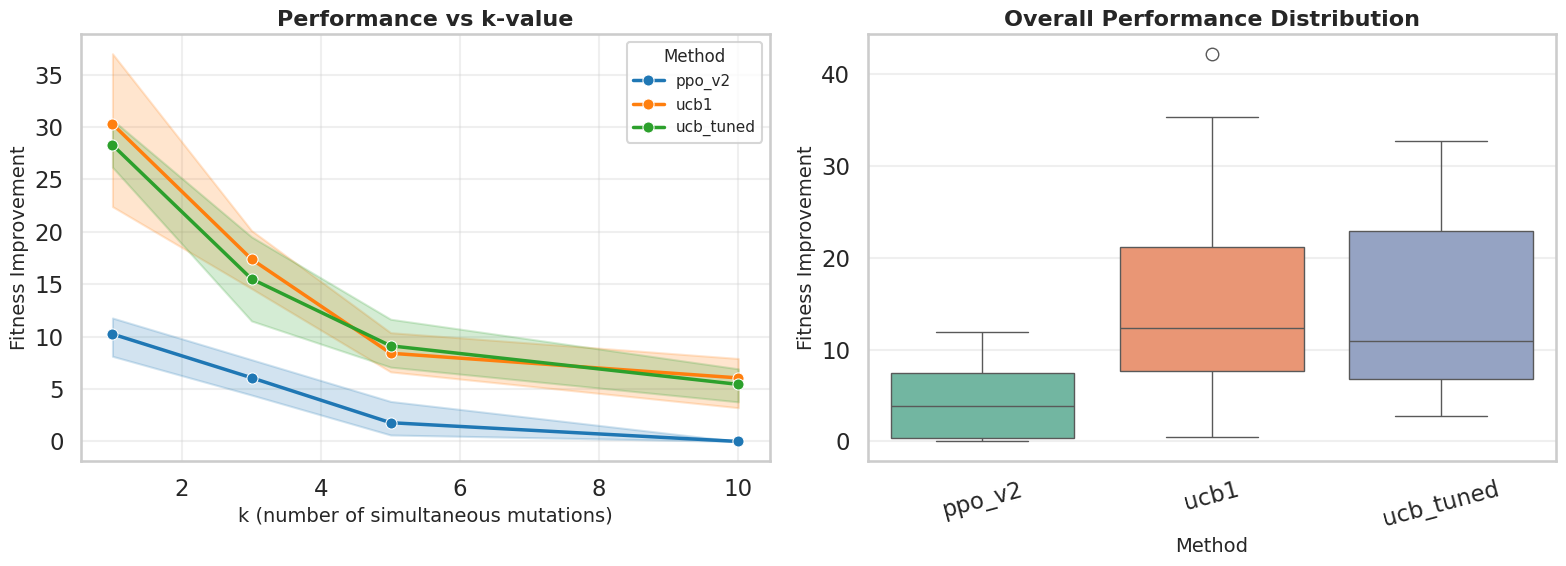

✓ Figure saved to: /content/drive/MyDrive/Protein_RL_Results/SAV1_MOUSE_improved_RL/detailed_comparison.png


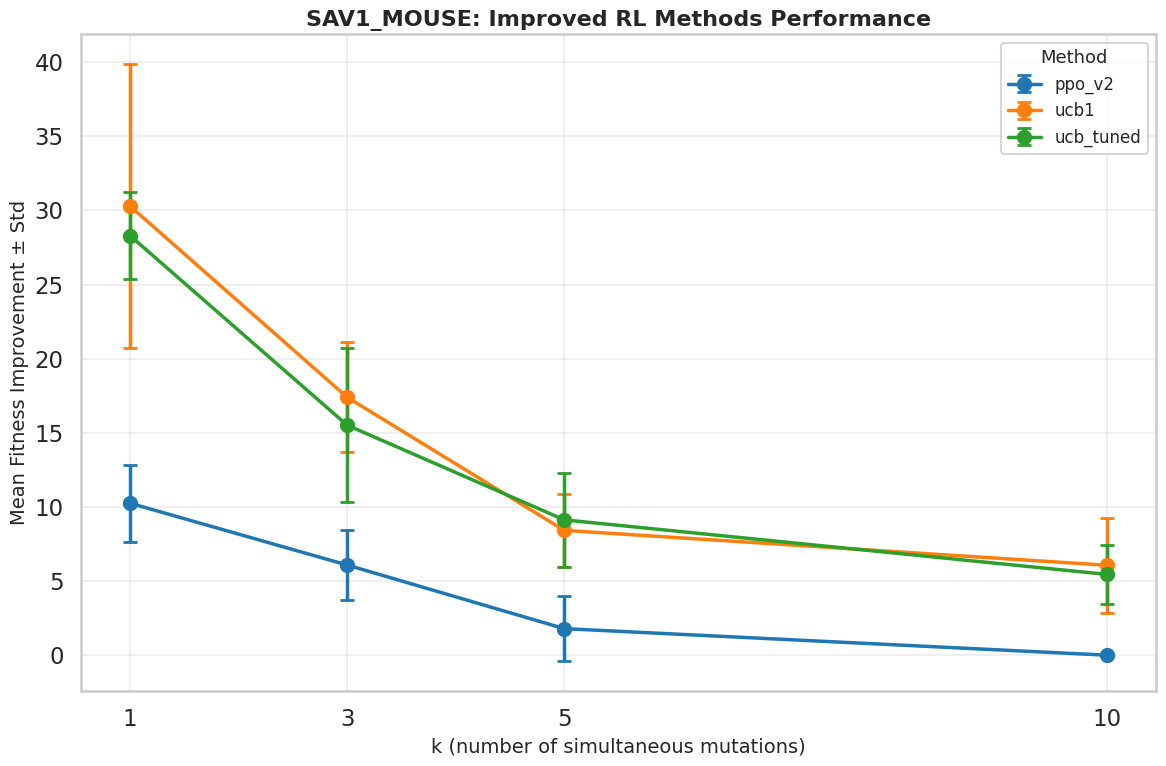

In [ ]:
# Cell 11: Visualizations (FIXED - uses pickle files)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
from pathlib import Path

output_dir = "/content/drive/MyDrive/Protein_RL_Results/SAV1_MOUSE_improved_RL"

# Load results from PICKLE files
results = []
for pkl_file in Path(output_dir).glob("result_*.pkl"):
    with open(pkl_file, 'rb') as f:
        result = pickle.load(f)
        # Extract summary (exclude history for plotting)
        summary = {k: v for k, v in result.items() if k != "history"}
        results.append(summary)

if len(results) > 0:
    df = pd.DataFrame(results)

    # Set style
    sns.set_style("whitegrid")
    sns.set_context("talk")

    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Improvement by k-value
    ax1 = axes[0]
    sns.lineplot(data=df, x='k', y='improvement', hue='method',
                 marker='o', markersize=8, linewidth=2.5, ax=ax1)
    ax1.set_xlabel('k (number of simultaneous mutations)', fontsize=14)
    ax1.set_ylabel('Fitness Improvement', fontsize=14)
    ax1.set_title('Performance vs k-value', fontsize=16, fontweight='bold')
    ax1.legend(title='Method', fontsize=11, title_fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Plot 2: Box plot by method
    ax2 = axes[1]
    sns.boxplot(data=df, x='method', y='improvement', palette='Set2', ax=ax2)
    ax2.set_xlabel('Method', fontsize=14)
    ax2.set_ylabel('Fitness Improvement', fontsize=14)
    ax2.set_title('Overall Performance Distribution', fontsize=16, fontweight='bold')
    ax2.tick_params(axis='x', rotation=15)
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()

    # Save figure
    fig_path = f'{output_dir}/performance_comparison.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✓ Figure saved to: {fig_path}")

    plt.show()

    # Create detailed comparison plot
    fig2, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Plot with error bars
    summary = df.groupby(['method', 'k'])['improvement'].agg(['mean', 'std']).reset_index()

    for method in df['method'].unique():
        method_data = summary[summary['method'] == method]
        ax.errorbar(method_data['k'], method_data['mean'],
                    yerr=method_data['std'],
                    marker='o', markersize=10, linewidth=2.5,
                    capsize=5, capthick=2, label=method)

    ax.set_xlabel('k (number of simultaneous mutations)', fontsize=14)
    ax.set_ylabel('Mean Fitness Improvement ± Std', fontsize=14)
    ax.set_title('SAV1_MOUSE: Improved RL Methods Performance',
                 fontsize=16, fontweight='bold')
    ax.legend(title='Method', fontsize=12, title_fontsize=13)
    ax.grid(True, alpha=0.3)
    ax.set_xticks([1, 3, 5, 10])

    plt.tight_layout()

    # Save
    fig2_path = f'{output_dir}/detailed_comparison.png'
    plt.savefig(fig2_path, dpi=300, bbox_inches='tight')
    print(f"✓ Figure saved to: {fig2_path}")

    plt.show()

else:
    print("No results to plot yet.")